# Assignment2 Lung Nodule CT Image Binary Classification

This Assignmnet's main goal is classification of Lung Nodule. label is divided to Benign(False) and Malignant(True). This is Binary Classification, Data type is 3D image (Lung CT Image)

Lung Nodule is nodule less than 3 cm in size that mainly founded at inside of lung. Pulmonary nodules usually have no symptoms. Most pulmonary nodules are found through chest radiography. The diagnosis of a pulmonary nodule is made through chest X-rays and chest computed tomography.
In this project, I will do classification with efforts for hight accuracy. I will also do image preprocessing for high accuracy.


## Data Preview
3,000 3D patches with a lung nodule in the center point, size is 32cm * 32cm * 16, Diameter of nodule is 8.31+-4.76cm. Total 2800 data, has 16 channels each of data. width * height = 32 * 32
train : validation = 2600 : 200 (90% : 10%) 

## Import Libraries & Reading Data 

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline
from tqdm import tqdm
import numpy as np

In [ ]:
dat = np.load("/content/drive/MyDrive/뇌 및 머신러닝/Assignment2/trn_dat.npy") #Should contain (2800,32,32,16) float32 numpy array
lbl = np.load("/content/drive/MyDrive/뇌 및 머신러닝/Assignment2/trn_lbl.npy") #Should contain (2800,) boolean numpy array

In [ ]:
np.shape(dat), np.shape(lbl)
# We can see data is loaded correctly. 

((2800, 32, 32, 16), (2800,))

In [ ]:
lbl
# divided False(Benign) and True(Malignant)

array([False, False, False, ...,  True,  True,  True])

In [ ]:
lbl = np.where(lbl=='True', 0, lbl)
lbl = np.where(lbl=='False',0, lbl)
lbl
# For Run Code Clearly, Benign changes to 0, Malignant changes to 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
df = np.swapaxes(dat, 1, 3)
np.shape(df)
# dat dimension is (2800, 32, 32, 16) (4-dimensional). 16 images sized 32 * 32 are combined to one bundle.
# and data is 2800 bundle. 
# in numpy, (2800, 16, 32, 32) dimension is more easier dimension type than (2800, 32, 32, 16)
# So I changed dimension order

(2800, 16, 32, 32)

In [ ]:
dataframe = pd.DataFrame(df[1][1])
dataframe
# example of 32 * 32 size image. We can see weight that distributed to -400 ~ -1000

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,-770.0,-742.0,-770.0,-833.0,-875.0,-893.0,-865.0,-844.0,-685.0,-416.0,-592.0,-835.0,-885.0,-875.0,-875.0,-893.0,-899.0,-907.0,-925.0,-919.0,-862.0,-848.0,-915.0,-919.0,-923.0,-868.0,-647.0,-665.0,-867.0,-931.0,-900.0,-833.0
1,-846.0,-838.0,-850.0,-877.0,-875.0,-869.0,-865.0,-829.0,-774.0,-632.0,-695.0,-855.0,-896.0,-883.0,-870.0,-903.0,-913.0,-906.0,-910.0,-885.0,-849.0,-854.0,-904.0,-909.0,-923.0,-897.0,-815.0,-781.0,-866.0,-916.0,-908.0,-864.0
2,-898.0,-903.0,-901.0,-906.0,-874.0,-850.0,-855.0,-808.0,-814.0,-791.0,-820.0,-872.0,-882.0,-862.0,-842.0,-894.0,-923.0,-914.0,-855.0,-713.0,-766.0,-843.0,-868.0,-874.0,-895.0,-881.0,-868.0,-858.0,-877.0,-910.0,-903.0,-822.0
3,-897.0,-905.0,-913.0,-933.0,-900.0,-861.0,-852.0,-841.0,-843.0,-826.0,-866.0,-899.0,-893.0,-887.0,-884.0,-925.0,-930.0,-914.0,-839.0,-572.0,-688.0,-843.0,-859.0,-877.0,-893.0,-888.0,-839.0,-849.0,-899.0,-900.0,-871.0,-847.0
4,-895.0,-897.0,-916.0,-936.0,-893.0,-878.0,-874.0,-878.0,-844.0,-843.0,-879.0,-890.0,-907.0,-897.0,-894.0,-922.0,-913.0,-888.0,-844.0,-651.0,-754.0,-898.0,-918.0,-911.0,-902.0,-894.0,-863.0,-900.0,-901.0,-900.0,-896.0,-889.0
5,-902.0,-888.0,-901.0,-906.0,-880.0,-885.0,-890.0,-896.0,-862.0,-866.0,-888.0,-896.0,-918.0,-913.0,-895.0,-913.0,-913.0,-903.0,-893.0,-823.0,-854.0,-918.0,-924.0,-910.0,-916.0,-918.0,-914.0,-931.0,-917.0,-908.0,-905.0,-896.0
6,-909.0,-888.0,-897.0,-891.0,-906.0,-895.0,-886.0,-902.0,-889.0,-888.0,-892.0,-900.0,-899.0,-885.0,-874.0,-897.0,-897.0,-898.0,-927.0,-901.0,-893.0,-905.0,-912.0,-910.0,-908.0,-910.0,-924.0,-928.0,-913.0,-923.0,-870.0,-806.0
7,-888.0,-873.0,-887.0,-887.0,-904.0,-878.0,-881.0,-925.0,-922.0,-909.0,-899.0,-903.0,-888.0,-830.0,-824.0,-879.0,-910.0,-916.0,-919.0,-900.0,-898.0,-892.0,-889.0,-881.0,-882.0,-898.0,-928.0,-916.0,-908.0,-918.0,-863.0,-790.0
8,-888.0,-883.0,-888.0,-895.0,-902.0,-886.0,-883.0,-910.0,-912.0,-900.0,-903.0,-908.0,-890.0,-847.0,-851.0,-870.0,-902.0,-907.0,-893.0,-870.0,-884.0,-901.0,-887.0,-889.0,-911.0,-909.0,-928.0,-927.0,-905.0,-906.0,-906.0,-895.0
9,-867.0,-881.0,-890.0,-888.0,-893.0,-889.0,-888.0,-904.0,-908.0,-915.0,-912.0,-912.0,-908.0,-895.0,-870.0,-833.0,-892.0,-913.0,-844.0,-815.0,-855.0,-895.0,-913.0,-917.0,-924.0,-925.0,-931.0,-920.0,-872.0,-895.0,-917.0,-922.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


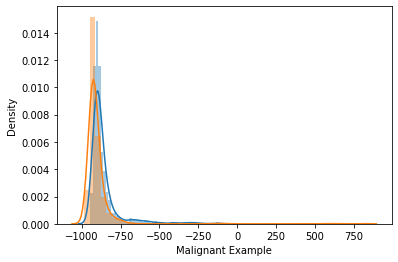

In [ ]:
np.shape(df[1][1])
f = df[1][1].flatten()
f = pd.DataFrame(f)
f = f.rename(columns={ 0: "Benign Example"}, errors="raise")
x = df[1400][1].flatten()
x = pd.DataFrame(x)
x = x.rename(columns={ 0: "Malignant Example"}, errors="raise")
fx = pd.concat([f,x], axis=1, sort=False)
import seaborn as sbn
sbn.distplot(fx['Benign Example'])
sbn.distplot(fx['Malignant Example'])
# visualization distplot of values of 32 * 32 image and can see difference between benign and malignant 
# We can see most of values distributed at -500 ~ 1000
# But a few of values distributed at -250 ~ 750. I wonder what type of pixel can get that values.

# Image Preprocessing

Because this data is 3D image, image preprocessing is necessary. I checked difference between benign and malignant, do preprocessing

0


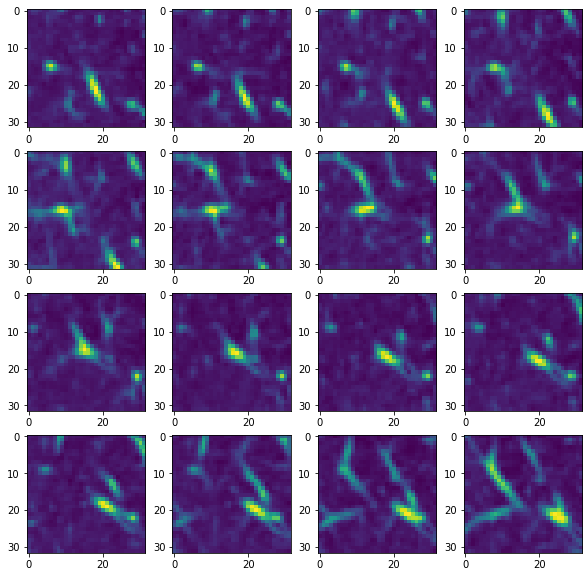

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(4,4, figsize=(10,10))
IMG_SIZE = 32
for i,ax in enumerate(axes.flat):
    ex = ax.imshow(df[1][i], interpolation='nearest')
print(lbl[1]) # Benign 0 <= x <= 1399
# 2800 bundle is tied up to 16 images. this is benign bundlle.
# We can see lots of yellow parts. I guess they are lung nodules. 
# This is representative example. I saw other bundles and they also had lots of yellow parts
# And I use basic interpolation name 'nearest' which is follow nearest pixel

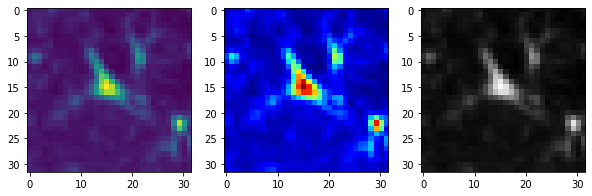

In [ ]:
fig, (ax,ax_jet, ax_gray) = plt.subplots(ncols=3, figsize=(10, 5))
ax.imshow(df[1][8],interpolation='nearest')
ax_gray.imshow(df[1][8], interpolation='nearest' ,cmap='gray');
ax_jet.imshow(df[1][8], interpolation='nearest', cmap='jet')
# I tried to change color type of image. In 'jet' type (2nd pic), I can see nodules most clearly.
# but if I use this color, I had to change 2800 * 16 images. So I thought that runtime will increase a lot.

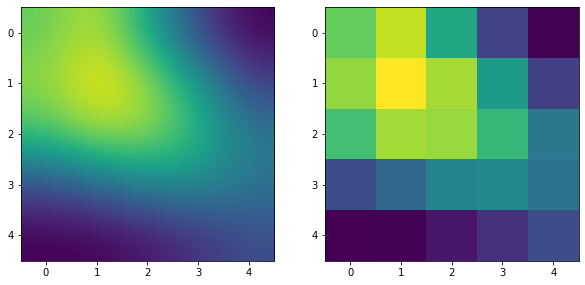

In [ ]:
fig, (ax_int,ax) = plt.subplots(ncols=2, figsize=(10, 5))
ax_int.imshow(df[1][8][14:19,14:19],interpolation='bicubic')
ax.imshow(df[1][8][14:19,14:19],interpolation='nearest')
# I tried to change interpolation. I choose interpolation name 'bicubic'
# you can see image changes really clear.

1


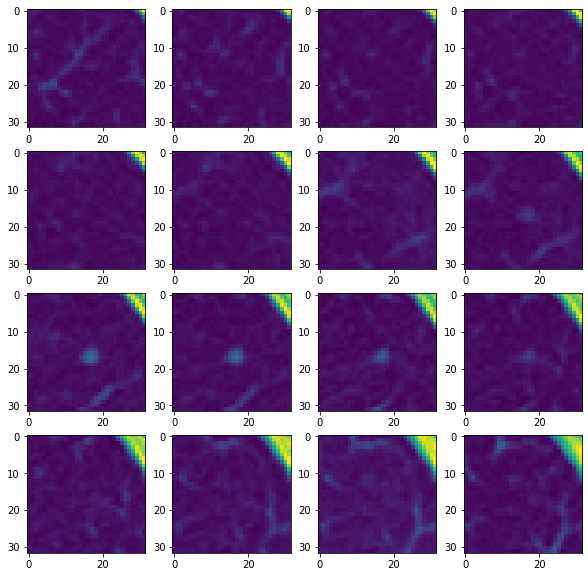

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(4,4, figsize=(10,10))
for i,ax in enumerate(axes.flat):
    ex = ax.imshow(df[1400][i], interpolation='nearest')
print(lbl[1400]) #Malignant 1400 <= x <= 2800
# this is malignant bundlle.
# We almost can't see yellow parts. 
# This is representative example. Likewise, other bundles also couldn't see yellow parts.
# And I also use basic interpolation name 'nearest' which is follow nearest pixel
# Thanks to this code, I can divide benign and malignant clearly.

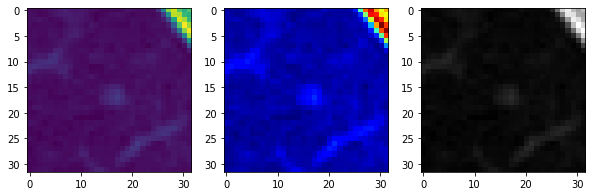

In [ ]:
fig, (ax,ax_jet, ax_gray) = plt.subplots(ncols=3, figsize=(10, 5))
ax.imshow(df[1400][7],interpolation='nearest')
ax_gray.imshow(df[1400][7], interpolation='nearest' ,cmap='gray');
ax_jet.imshow(df[1400][7], interpolation='nearest', cmap='jet')
# Malignant cmap compare code

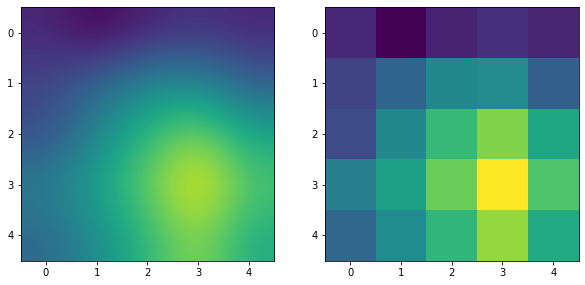

In [ ]:
fig, (ax_int,ax) = plt.subplots(ncols=2, figsize=(10, 5))
ax_int.imshow(df[1400][7][14:19,14:19],interpolation='bicubic')
ax.imshow(df[1400][7][14:19,14:19],interpolation='nearest')
# Malignant interpolation compare code

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
# In pytorch, transform part is very important. For cnn model, ToTensor funcion which changes image to pytorch tensor is necessary. 
# We can do many preprocessings.
# changes to gray : GrayScale tf.Grayscale(), Cut images randomly (with resize) : tf.RandomCrop(), tf.RandomResizedCrop()
# Flip images randomly (horizontal or vertical) : tf.RandomHorizontalFlip(), tf.RandomVerticalFlip()
# Normalize : tf.Normalization(), and I tried to use tf.RandomHorizontalFlip()

In [ ]:
train_set, test_set = torch.utils.data.random_split(df,[2600,200])
np.shape(train_set)
# Check dimension, split amount code

(2600, 16, 32, 32)

torch.Size([3, 32, 32])

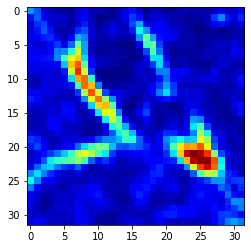

In [ ]:
for i in range(2):
  for t in range(16):
    image = plt.imshow(df[i][t],interpolation='nearest',cmap='jet')
    image = Image.fromarray(df[i][t],'RGB')
image=train_transform(image)
image.size()
# Pre-check for LUNAData Class.

In [ ]:
class LUNAData(Dataset):
    def __init__(self,transform):
        self.data = df #wap
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        for i in range(2800):
          for t in range(16):
            # image = plt.imshow(df[i][t],interpolation='nearest',cmap='jet')
            image = Image.fromarray(df[i][t],'RGB')
        image = self.transform(image)
        label = torch.tensor(lbl[idx,])
        return {'image': image,
                'labels': label}
# I made class name 'LUNAData'. This class, it processes automatically.
# transform ndarray data -> merge dat and lbl code in one array and you can insert preprocessing code if you want
# trnasform, fromarray, label tensor change in one class

In [ ]:
wap = torch.tensor(df) # dat
train_set, test_set = torch.utils.data.random_split(wap,[2600,200])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=0,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=True, num_workers=0,drop_last=True)
train_set[1][15]
# (2600,16,32,32)
# Dimension, code check before use dataloader
# In this code, test mean validation. (10% 200 data)

tensor([[ 130.,  121.,  139.,  ..., -500., -369., -429.],
        [  84.,   54.,  107.,  ..., -349., -132., -380.],
        [  60.,   17.,   99.,  ...,   58.,  107., -196.],
        ...,
        [ 189.,  203.,  182.,  ...,  182.,  204.,  182.],
        [ 219.,  221.,  175.,  ...,  142.,  207.,  225.],
        [ 196.,  155.,  187.,  ...,   43.,  114.,   44.]])

In [ ]:
Dataset = LUNAData(transform=train_transform)
train_set, test_set = torch.utils.data.random_split(Dataset,[2600,200])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=0,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=True, num_workers=0,drop_last=True)
train_set[1]
# Start with LUNAData class, split 9:1 train_validation split and Dataloader code for run pytorch CNN
# you can see 'image' and 'label' inserted at one layer
# But, I can see lots of 0.0000 values in image tensor. 
# dimension is right but 0.000 values will make problems. I should check this problem.

{'image': tensor([[[0.0000, 0.2627, 0.9176,  ..., 0.7686, 0.2039, 0.5020],
          [0.0000, 0.7686, 0.3255,  ..., 0.7686, 0.3137, 0.2510],
          [0.0000, 0.7686, 0.3608,  ..., 0.7686, 0.3176, 0.2510],
          ...,
          [0.0000, 0.7686, 0.2980,  ..., 0.7686, 0.2588, 0.2510],
          [0.0000, 0.7686, 0.2941,  ..., 0.7686, 0.2275, 0.0000],
          [0.0000, 0.7686, 0.2196,  ..., 0.7686, 0.3216, 0.5020]],
 
         [[0.0000, 0.0000, 0.2588,  ..., 0.0000, 0.7686, 0.1725],
          [0.0000, 0.0000, 0.7686,  ..., 0.0000, 0.7686, 0.3373],
          [0.7529, 0.0000, 0.7686,  ..., 0.0000, 0.7686, 0.3255],
          ...,
          [0.2510, 0.0000, 0.7686,  ..., 0.0000, 0.7686, 0.2235],
          [0.5020, 0.0000, 0.7686,  ..., 0.0000, 0.7686, 0.2549],
          [0.7529, 0.0000, 0.7686,  ..., 0.0000, 0.7686, 0.3216]],
 
         [[0.5961, 0.0000, 0.0000,  ..., 0.7529, 0.0000, 0.7686],
          [0.2863, 0.7529, 0.0000,  ..., 0.0000, 0.0000, 0.7686],
          [0.3529, 0.7529, 0.00

# Before Use Model
Before making code of this assignment, I have to think lots of elements and methods. first of all, dataset is 3D image. In 3d modeling, I think some methods but it is very hard to modeling. Anyway, I thought 3 methods to modeling this data.

1. Use 3D CNN that can run 3D image at it is. (dimension frame is 5. width*height*color*channel*bundles)

2. Change Data to 2D patch, use 2D CNN (Normal CNN or Ensemble CNN) - change dimension and shape of data, put into normal CNN or Ensemble CNN.

3. Make each features to column. Then use Machine Learning. (RandomForest, Decision Treem SVM etc .. )

I can't use 3D CNN. So at first, I will tried to use methods number 2 and 3 I have to fit dimension and shape for each models.


## Method 2 : VGG19
batchsize = 64, learning_rate = 0.01, num_epoch = 5, CrossEntropyLoss()
optimier = Adam

First, it was decided to use VGG19, a model of VGG, an Oxford research team that won second place in the 2014 ImageNet image recognition competition.
I was impressed with the good performance despite being simpler than the winning GoogLeNet. So I decided to use the VGG19 model. There are 19 layers, and ReLU is used and the output value is activated by softmax.



In [ ]:
VGG19 = torchvision.models.vgg19(pretrained = True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG19.to(device)
learning_rate = 0.001
num_epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)
device
# Choose learning rate, optimizer, loss_funcion, scheduler.
# I was wavering between optimizers (adam, RMS etc ..). I tried to use adam which is shown high efficents.
# loss is cross entropy loss.

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


device(type='cuda', index=0)

In [ ]:
loss_arr = []
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,batch in enumerate(train_loader):
        x = batch['image'].to(device)
        y = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model.forward(x) 
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())           
# fit the train and check loss. x is image tensor, y is label tensor
# Process : input -> forward -> loss check -> backward(backpropagation) -> optimizer -> repeated until num_epoch.

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(16.1877, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6680, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7041, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for b,di in enumerate(test_loader):
        x_ = di['image'].to(device)
        y_ = di['labels'].to(device)
        
        output = model.forward(x_)
        _,output_index = torch.max(output,1)
        
        total += y_.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))
# Accuacy of validation data. I can't get high accuracy that I expected. so I decided to analyze this output.
# test_loader, test_set = validation_loader, validation_set in assignment

Accuracy of Test Data: 58.333335876464844


## Method 2 : GoogleNet
batchsize = 64, learning_rate = 0.01, num_epoch = 5, CrossEntropyLoss() optimier = Adam, image = jet

22 layers deep network, was used to assess its quality in the context of object detection and classification. batchsize changes to 64. because runtime and reduce optimize epoch. 

In [ ]:
GoogleNet = torchvision.models.googlenet(pretrained = True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GoogleNet.to(device)
learning_rate = 0.01
num_epoch = 5
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)
device

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


device(type='cuda', index=0)

In [ ]:
loss_arr = []
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,batch in enumerate(train_loader):
        x = batch['image'].to(device)
        y = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model.forward(x) 
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(7.6913, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9804, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7623, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7352, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for b,di in enumerate(test_loader):
        x_ = di['image'].to(device)
        y_ = di['labels'].to(device)
        
        output = model.forward(x_)
        _,output_index = torch.max(output,1)
        
        total += y_.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 53.125


### Analysis Method 2
I use second method (2D CNN, use image patches to 2D). At the results, accuracy was not good. I guessed several causes.

1. I implemented 2D CNN on 3D image. So, it seems that the difference in dimensions and distortion of the data resulted in a bad result.To solve this problem, I think I should use 3D CNN or 2D CNN Ensemble. I think CT - image should use 3D ConV, 3D ResNet or 2D CNN Ensemble. Summarize, dimension of data is problem

2. There seems to be a problem in the process of transforming and adjusting the hyparameter. I looked at the data in the Transform process,There was little difference in the Tensor value, (0~1 actual number) Many tensors with a weight of 0.0000 were found. So, it seems that the data of the image is greatly distorted during the transform process.

Based on these results, I decided to use Method 3.

## Method 3 : Machine Learning (RandomForest)

In [ ]:
# reshaped = dat
np.shape(dat)
reshaped = dat.reshape(2800,16384)
np.shape(reshaped)
reshaped = pd.DataFrame(reshaped)
label = pd.DataFrame(lbl)
reshaped
# 2800 bundle has 16 images sized 32 * 32. All of 16 * 32 * 32 put in to each column. Then, Change to pd.DataFrame
# Use Machine Learning to classification. It is not image anymore. but only nodule tensors still remain
# also each bundle exists same column at same image position. So, image's weights are still remained.
# I consider using normalization. but values spread moderately, well organized. so I decided to pass normalization

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16344,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,-898.0,-922.0,-918.0,-906.0,-901.0,-894.0,-881.0,-866.0,-849.0,-854.0,-877.0,-901.0,-925.0,-929.0,-925.0,-867.0,-931.0,-943.0,-938.0,-929.0,-903.0,-877.0,-856.0,-840.0,-830.0,-843.0,-873.0,-901.0,-928.0,-906.0,-879.0,-850.0,-884.0,-862.0,-868.0,-882.0,-846.0,-797.0,-689.0,-659.0,...,-776.0,-741.0,-670.0,-659.0,-668.0,-684.0,-707.0,-766.0,-776.0,-771.0,-689.0,-584.0,-616.0,-661.0,-751.0,-810.0,-810.0,-757.0,-660.0,-607.0,-568.0,-640.0,-715.0,-755.0,-807.0,-788.0,-701.0,-596.0,-670.0,-744.0,-798.0,-829.0,-819.0,-756.0,-650.0,-604.0,-580.0,-583.0,-594.0,-653.0
1,-857.0,-770.0,-667.0,-650.0,-719.0,-809.0,-861.0,-900.0,-903.0,-894.0,-890.0,-876.0,-865.0,-844.0,-809.0,-669.0,-888.0,-846.0,-774.0,-682.0,-662.0,-700.0,-725.0,-823.0,-892.0,-897.0,-902.0,-883.0,-877.0,-880.0,-862.0,-796.0,-909.0,-898.0,-878.0,-836.0,-813.0,-741.0,-678.0,-763.0,...,-867.0,-849.0,-843.0,-869.0,-858.0,-836.0,-781.0,-696.0,-932.0,-917.0,-901.0,-914.0,-898.0,-870.0,-869.0,-890.0,-883.0,-874.0,-872.0,-901.0,-874.0,-860.0,-884.0,-820.0,-903.0,-904.0,-913.0,-914.0,-897.0,-882.0,-881.0,-886.0,-886.0,-873.0,-870.0,-893.0,-880.0,-906.0,-903.0,-703.0
2,-679.0,-604.0,-518.0,-417.0,-294.0,-188.0,-93.0,-64.0,-53.0,-59.0,-61.0,-41.0,-15.0,19.0,41.0,52.0,-691.0,-641.0,-585.0,-492.0,-347.0,-226.0,-122.0,-80.0,-56.0,-74.0,-90.0,-94.0,-81.0,-38.0,-9.0,8.0,-724.0,-685.0,-634.0,-554.0,-432.0,-294.0,-147.0,-102.0,...,-850.0,-880.0,-903.0,-893.0,-874.0,-841.0,-836.0,-853.0,-882.0,-888.0,-894.0,-886.0,-860.0,-857.0,-872.0,-880.0,-886.0,-892.0,-895.0,-890.0,-876.0,-848.0,-844.0,-859.0,-855.0,-856.0,-890.0,-917.0,-932.0,-934.0,-926.0,-912.0,-897.0,-885.0,-876.0,-886.0,-887.0,-873.0,-862.0,-854.0
3,-867.0,-872.0,-865.0,-857.0,-842.0,-828.0,-813.0,-799.0,-784.0,-797.0,-814.0,-836.0,-847.0,-823.0,-811.0,-815.0,-874.0,-870.0,-869.0,-854.0,-802.0,-741.0,-671.0,-597.0,-522.0,-546.0,-590.0,-713.0,-816.0,-857.0,-880.0,-879.0,-869.0,-869.0,-882.0,-886.0,-865.0,-816.0,-737.0,-636.0,...,-570.0,-655.0,-717.0,-762.0,-811.0,-868.0,-901.0,-903.0,-848.0,-890.0,-875.0,-812.0,-626.0,-459.0,-311.0,-378.0,-549.0,-672.0,-781.0,-777.0,-786.0,-836.0,-880.0,-914.0,-883.0,-915.0,-888.0,-844.0,-757.0,-674.0,-594.0,-636.0,-738.0,-814.0,-879.0,-843.0,-822.0,-849.0,-878.0,-908.0
4,52.0,-2.0,-26.0,-38.0,-7.0,2.0,-29.0,-54.0,-95.0,-112.0,-139.0,-179.0,-223.0,-325.0,-403.0,-367.0,72.0,69.0,11.0,4.0,8.0,39.0,30.0,7.0,-17.0,-10.0,11.0,-51.0,-60.0,-100.0,-129.0,-228.0,44.0,32.0,-20.0,-17.0,-19.0,-10.0,22.0,45.0,...,-767.0,-796.0,-844.0,-835.0,-769.0,-774.0,-818.0,-812.0,-809.0,-753.0,-543.0,-362.0,-574.0,-753.0,-798.0,-824.0,-824.0,-809.0,-810.0,-812.0,-777.0,-796.0,-795.0,-775.0,-741.0,-640.0,-463.0,-431.0,-701.0,-817.0,-792.0,-799.0,-822.0,-812.0,-751.0,-806.0,-846.0,-820.0,-821.0,-802.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-98.0,-114.0,-111.0,-103.0,-100.0,-110.0,-120.0,-119.0,-114.0,-107.0,-92.0,-76.0,-84.0,-99.0,-111.0,-105.0,-93.0,-115.0,-110.0,-99.0,-94.0,-106.0,-119.0,-119.0,-115.0,-111.0,-105.0,-100.0,-104.0,-113.0,-118.0,-109.0,-64.0,-96.0,-100.0,-96.0,-97.0,-110.0,-123.0,-127.0,...,-823.0,-905.0,-941.0,-978.0,-956.0,-912.0,-883.0,-909.0,-442.0,-280.0,-360.0,-504.0,-625.0,-684.0,-743.0,-782.0,-815.0,-849.0,-886.0,-924.0,-878.0,-801.0,-759.0,-845.0,-438.0,-354.0,-477.0,-656.0,-789.0,-801.0,-814.0,-832.0,-852.0,-852.0,-790.0,-729.0,-624.0,-503.0,-448.0,-639.0
2796,-

In [ ]:
result3 = pd.concat([reshaped,label],axis=1)
result3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383,0
0,-898.0,-922.0,-918.0,-906.0,-901.0,-894.0,-881.0,-866.0,-849.0,-854.0,-877.0,-901.0,-925.0,-929.0,-925.0,-867.0,-931.0,-943.0,-938.0,-929.0,-903.0,-877.0,-856.0,-840.0,-830.0,-843.0,-873.0,-901.0,-928.0,-906.0,-879.0,-850.0,-884.0,-862.0,-868.0,-882.0,-846.0,-797.0,-689.0,-659.0,...,-741.0,-670.0,-659.0,-668.0,-684.0,-707.0,-766.0,-776.0,-771.0,-689.0,-584.0,-616.0,-661.0,-751.0,-810.0,-810.0,-757.0,-660.0,-607.0,-568.0,-640.0,-715.0,-755.0,-807.0,-788.0,-701.0,-596.0,-670.0,-744.0,-798.0,-829.0,-819.0,-756.0,-650.0,-604.0,-580.0,-583.0,-594.0,-653.0,0
1,-857.0,-770.0,-667.0,-650.0,-719.0,-809.0,-861.0,-900.0,-903.0,-894.0,-890.0,-876.0,-865.0,-844.0,-809.0,-669.0,-888.0,-846.0,-774.0,-682.0,-662.0,-700.0,-725.0,-823.0,-892.0,-897.0,-902.0,-883.0,-877.0,-880.0,-862.0,-796.0,-909.0,-898.0,-878.0,-836.0,-813.0,-741.0,-678.0,-763.0,...,-849.0,-843.0,-869.0,-858.0,-836.0,-781.0,-696.0,-932.0,-917.0,-901.0,-914.0,-898.0,-870.0,-869.0,-890.0,-883.0,-874.0,-872.0,-901.0,-874.0,-860.0,-884.0,-820.0,-903.0,-904.0,-913.0,-914.0,-897.0,-882.0,-881.0,-886.0,-886.0,-873.0,-870.0,-893.0,-880.0,-906.0,-903.0,-703.0,0
2,-679.0,-604.0,-518.0,-417.0,-294.0,-188.0,-93.0,-64.0,-53.0,-59.0,-61.0,-41.0,-15.0,19.0,41.0,52.0,-691.0,-641.0,-585.0,-492.0,-347.0,-226.0,-122.0,-80.0,-56.0,-74.0,-90.0,-94.0,-81.0,-38.0,-9.0,8.0,-724.0,-685.0,-634.0,-554.0,-432.0,-294.0,-147.0,-102.0,...,-880.0,-903.0,-893.0,-874.0,-841.0,-836.0,-853.0,-882.0,-888.0,-894.0,-886.0,-860.0,-857.0,-872.0,-880.0,-886.0,-892.0,-895.0,-890.0,-876.0,-848.0,-844.0,-859.0,-855.0,-856.0,-890.0,-917.0,-932.0,-934.0,-926.0,-912.0,-897.0,-885.0,-876.0,-886.0,-887.0,-873.0,-862.0,-854.0,0
3,-867.0,-872.0,-865.0,-857.0,-842.0,-828.0,-813.0,-799.0,-784.0,-797.0,-814.0,-836.0,-847.0,-823.0,-811.0,-815.0,-874.0,-870.0,-869.0,-854.0,-802.0,-741.0,-671.0,-597.0,-522.0,-546.0,-590.0,-713.0,-816.0,-857.0,-880.0,-879.0,-869.0,-869.0,-882.0,-886.0,-865.0,-816.0,-737.0,-636.0,...,-655.0,-717.0,-762.0,-811.0,-868.0,-901.0,-903.0,-848.0,-890.0,-875.0,-812.0,-626.0,-459.0,-311.0,-378.0,-549.0,-672.0,-781.0,-777.0,-786.0,-836.0,-880.0,-914.0,-883.0,-915.0,-888.0,-844.0,-757.0,-674.0,-594.0,-636.0,-738.0,-814.0,-879.0,-843.0,-822.0,-849.0,-878.0,-908.0,0
4,52.0,-2.0,-26.0,-38.0,-7.0,2.0,-29.0,-54.0,-95.0,-112.0,-139.0,-179.0,-223.0,-325.0,-403.0,-367.0,72.0,69.0,11.0,4.0,8.0,39.0,30.0,7.0,-17.0,-10.0,11.0,-51.0,-60.0,-100.0,-129.0,-228.0,44.0,32.0,-20.0,-17.0,-19.0,-10.0,22.0,45.0,...,-796.0,-844.0,-835.0,-769.0,-774.0,-818.0,-812.0,-809.0,-753.0,-543.0,-362.0,-574.0,-753.0,-798.0,-824.0,-824.0,-809.0,-810.0,-812.0,-777.0,-796.0,-795.0,-775.0,-741.0,-640.0,-463.0,-431.0,-701.0,-817.0,-792.0,-799.0,-822.0,-812.0,-751.0,-806.0,-846.0,-820.0,-821.0,-802.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-98.0,-114.0,-111.0,-103.0,-100.0,-110.0,-120.0,-119.0,-114.0,-107.0,-92.0,-76.0,-84.0,-99.0,-111.0,-105.0,-93.0,-115.0,-110.0,-99.0,-94.0,-106.0,-119.0,-119.0,-115.0,-111.0,-105.0,-100.0,-104.0,-113.0,-118.0,-109.0,-64.0,-96.0,-100.0,-96.0,-97.0,-110.0,-123.0,-127.0,...,-905.0,-941.0,-978.0,-956.0,-912.0,-883.0,-909.0,-442.0,-280.0,-360.0,-504.0,-625.0,-684.0,-743.0,-782.0,-815.0,-849.0,-886.0,-924.0,-878.0,-801.0,-759.0,-845.0,-438.0,-354.0,-477.0,-656.0,-789.0,-801.0,-814.0,-832.0,-852.0,-852.0,-790.0,-729.0,-624.0,-503.0,-448.0,-639.0,1
2796,-913.0,-887.0,-860.0,-853.0,-875.0,

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
task1_RF = RandomForestClassifier()
task1_RF.fit(reshaped,label)
scores = cross_val_score(task1_RF, reshaped, label, cv=10)
scores.mean()
# RandomForest shows good performance at data that has many columns.
# At First, I learned model without hyperparameter tuning.
# If I use 10-CrossValidation methods, train_validation splits into 9:1.
# It means I split into 9 : 1. cv=10 mean 10-fold crossvalidation.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

0.8028571428571428

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_param_grid = {
    'n_estimators' :[1,5,10],
    'max_depth' : [2,5,10,12],
    'min_samples_leaf' : [2,5,10],
    'min_samples_split' : [2,5,8]
}
rf_grid =GridSearchCV(task1_RF, param_grid = rf_param_grid,scoring='accuracy',n_jobs = -1, verbose=1)
rf_grid.fit(data, label)
# Use GridSearchCV for find appropriate hyperparameter

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
best_param = rf_grid.best_params_
best_param
# best parameter that gridsearch found

{'max_depth': 12,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 10}

In [ ]:
RFparam = RandomForestClassifier(max_depth= 12,
 min_samples_leaf=5,
 min_samples_split= 2,
 n_estimators= 10)
RFparam.fit(reshaped,label)
scores = cross_val_score(RFparam, reshaped, label, cv=5)
scores.mean()
# Learn model again with hyperparameter
# But Accuracy is slightly down. I thought why.
# I think max_depth, min_sample_leaf ,, such hyperparameter means limits. so that hyperparemter regulate learn deeply.
# Actually, Learning time is quite faster than RF without hyperparmeter
# So, I think why accuracy goes slightly down.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

0.7735714285714287

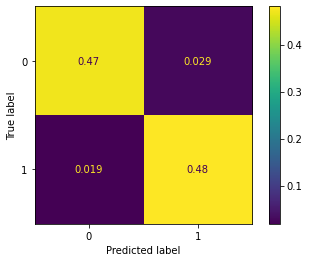

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RFparam, reshaped,label, normalize = 'all')
# this is confusion matrix, with four boxes.
# First quadrant mean False negative. predict 1 but answer is 0. wrong
# Second quadrant mean True Positives. predict 0 and answer is 0. correct
# Third quadrant mean False Positives. predict 0 but answer is 1. wrong
# Fourth quadrant mean True Negatives. predict 1 and answer is 1. correct
# 2,4 quadrant ratio is 0.47, 0.48. It means this model almost corrects the answer
# It seems model is well-trained

## Conclusion

As a result, I couldn't use perfect model what I wanted because lack of 3D image classification knowledge. but I learned a lot in progress. In that sence, this assignment is very meaningful. Thinking three methods to solve, efforts for the best results in each have taught me a lot. I learned how important it is to write my own code, search errors and analyze Google. The most thing missing is failed to use deep learning. I fail to complete 2D CNN model and couldn't make 3D Convolutional model. Afterwards, I really wanted to complete deep learning model. For that goal, I will study hard. thank you

## Pickle

In [ ]:
import pandas as pd
import numpy as np
dat = np.load("/content/drive/MyDrive/뇌 및 머신러닝/Assignment2/trn_dat.npy") #Should contain (2800,32,32,16) float32 numpy array
lbl = np.load("/content/drive/MyDrive/뇌 및 머신러닝/Assignment2/trn_lbl.npy") #Should contain (2800,) boolean numpy array
reshaped = dat.reshape(2800,16384)
reshaped = pd.DataFrame(reshaped)
label = pd.DataFrame(lbl)
from sklearn.ensemble import RandomForestClassifier
CTRF = RandomForestClassifier()
CTRF = CTRF.fit(reshaped,label)

import pickle

with open('cls_model.pkl', 'wb') as f:
	pickle.dump(CTRF, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
t = np.load("/content/drive/MyDrive/뇌 및 머신러닝/Assignment2/sample_evaluation_data.npy")
t = t.reshape(len(t),16384)
# np.shape(t)
t = pd.DataFrame(t)
model_output = np.zeros(shape=len(eval_data), dtype=np.uint8)
model_output = pd.DataFrame(model_output)
model_output = cls_model1.predict(t)
model_output = model_output.astype(np.uint8)
model_output